In [2]:
#Hunter Obendorfer
#1834106
#Python 3.7.11, OCV 3.4.2, MPL 3.4.3, numpy 1.21.2
#use high resolution images, I used 4608 × 2592 images

In [3]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
from skimage import measure
import imutils

path = "DataSet/"

#prepare image
def prepImg(img):
    #cvt to gray
    imgGray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    #blur
    blurred = cv.GaussianBlur(imgGray, (13,13), 0)
    #sharpen
    k = np.array([[0, -1, 0],
                  [-1, 5, -1],
                  [0, -1, 0]])
    sharp = cv.filter2D(blurred, -1, kernel=k)
    #Normalize grayscale to 0-255
    norm = cv.normalize(blurred, None, alpha = 0, beta = 255, norm_type = cv.NORM_MINMAX)
    return(norm)

In [4]:
#find burnt pieces of filament lodged in the object
#This is a result of an unclean nozzle
#cannont detect line-like burns, only blob like

#TODO: extract square ROI and search within that only
def findBurntSpot(img, objectColor = "white", retData=False):
    #unused for now, only considering objects made from white filament 
    #objectColor.lower()
    prepared = prepImg(img)
    #since brown is only slightly darker, a value that is not 0 or 255 should be
    #a burnt piece of filament embedded in the print
    #220 is a good value to use, found by testing
    
    #do range thresholding
    #change values in range to 255
    #values not in range are set to 0
    (height, width) = prepared.shape
    
    for x in range(0,width):
        for y in range(0, height):
            if(prepared[y][x] < 214):
                prepared[y][x] = 0
            elif (prepared[y][x] > 220):
                prepared[y][x] = 0
            else:
                prepared[y][x] = 255
    #^makes a half decent edge detector
    #remove small blobs
    prepared = cv.erode(prepared, None, iterations=4)
    prepared = cv.dilate(prepared, None, iterations=8)
    
    #remove edges, implement later
    #edges = cv.Canny(thresh, 50, 150)
    #thresh = thresh-edges
    
    #find blobs using connected component analysis
    #found here https://www.pyimagesearch.com/2016/10/31/detecting-multiple-bright-spots-in-an-image-with-python-and-opencv/
    
    labels = measure.label(prepared, background=0)
    mask = np.zeros(prepared.shape, dtype='uint8')
    for label in np.unique(labels):
        if label == 0:
            continue
        labelMask = np.zeros(prepared.shape, dtype='uint8')
        labelMask[labels == label] = 255
        numpixels = cv.countNonZero(labelMask)
        if(numpixels >= 4000):
            mask = cv.add(mask, labelMask)
    
    #finds contours
    contours = cv.findContours(mask.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    if(len(contours) > 0):
        if(retData):
            return(contours)
        else:
            print("Burns/blemishes found, clean the printer's nozzle inside and out.")
    return(contours)

In [5]:
#approximate the size of the object and determine how accurate your printer is
#height and width can be found in 3D printer stl slicer, cura has this
#information in the bottom left corner of the screen
#height/width must be in mm
#1 inch = 25.4 mm
#assuming all objects other than the cube are the same object

#TODO: minimize error by bad orientations
def determineSize(img, width, height, error=5.0, retData=False):
    #image must be oriented such that the calibration cube is the rightmost object
    prepared = prepImg(img)
    (h, w) = prepared.shape
    #use otsu's thresholding
    ret, thresh = cv.threshold(prepared, 0,255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    
    #remove small blobs
    thresh = cv.erode(thresh, None, iterations=4)
    thresh = cv.dilate(thresh, None, iterations=8)
    
    #grab contours
    labels = measure.label(thresh, background=0)
    mask = np.zeros(prepared.shape, dtype='uint8')
    for label in np.unique(labels):
        if label == 0:
            continue
        labelMask = np.zeros(prepared.shape, dtype='uint8')
        labelMask[labels == label] = 255
        numpixels = cv.countNonZero(labelMask)
        if(numpixels >= 4000):
            mask = cv.add(mask, labelMask)
            
    #finds contours
    cnt = cv.findContours(mask.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnt = imutils.grab_contours(cnt)
    
    #find bounding rectangles
    pos = 0
    rightMost = 0
    rect = []
    retImg = img.copy()
    for (i, c) in enumerate(cnt):
        #get min area rectangle and the 4 points
        boundRect = cv.minAreaRect(c) # (center(x,y), (width, height), angle)
        box=cv.boxPoints(boundRect)
        box=np.int0(box)
        cv.drawContours(retImg, [box], 0, (0,255,0), 5)
        
        rect.append(boundRect) #
        if(boundRect[0][0] > rightMost):
            rightMost = boundRect[0][0]
            #label position x of rightmost in rectangle array
            pos=i
    
    #number of pixels for 20 mm
    calibratedX = rect[pos][1][0]
    
    #difference between x and y calibration, perspective is not perfect
    #assuming same depth, subtract the difference from the height to get
    #more accurate estimation
    XYDiff = rect[pos][0][1] - rect[pos][0][0]
    
    #draw bounding rectangles and print sizes/accuracy
    avgErrX = 0.0
    avgErrY = 0.0
    avgH = 0.0
    avgW = 0.0
    for i in range(0, len(rect)):
        if(i != pos):             #ignore cube
            
            #calculate size/error
            sizeX = 20.0 * (rect[i][1][0]/calibratedX)
            sizeY = 20.0 * (rect[i][1][1]/calibratedX)
            errX = (abs(sizeX-width)/width)*100
            errY = (abs(sizeY-height)/height)*100
            
            #add to avgs
            avgErrX = avgErrX+errX
            avgErrY = avgErrY+errY
            avgH = avgH+sizeY
            avgW = avgW+sizeX
            print((sizeX, sizeY, errX, errY))
    
    avgErrX = avgErrX/(len(rect)-1)
    avgErrY = avgErrY/(len(rect)-1)
    avgW=avgW/(len(rect)-1)
    avgH=avgH/(len(rect)-1)

    if(retData):        #return data only
        return (avgW, avgH)

    if(avgErrX>error or avgErrY > error):
        print("Recalibrate steps/mm\nTutorial here: https://all3dp.com/2/how-to-calibrate-a-3d-printer-simply-explained/")
    cv.putText(retImg, 
               "Width: {:.2f} mm, Height: {:.2f} mm, X error: {:.2f}%, Y error: {:.2f}%".format(avgW,avgH,avgErrX,avgErrY),
                (100, h-100), cv.FONT_HERSHEY_PLAIN, 8, (0,255,0), 5)
            
    retImg = cv.cvtColor(retImg, cv.COLOR_BGR2RGB) #cvt before hand
    
    return(retImg)

In [8]:
#detect elephant's foot

#splitting images https://oleksandrg.medium.com/how-to-divide-the-image-into-4-parts-using-opencv-c0afb5cab10c

#TODO: make more robust using this method
#https://stackoverflow.com/questions/37177811/crop-rectangle-returned-by-minarearect-opencv-python
def findElephantFoot(img, error=5.0, retData=False):
    errorMSG = "Elephant's foot detected, re-level the print bed.\nGuide here: https://all3dp.com/2/3d-printer-bed-leveling-step-by-step-tutorial/\nThe author of this software recommends using feeler gauges, not paper to re-level the bed."
    prep = prepImg(img)
    #split image, use right side only
    (origH, origW) = prep.shape
    
    #take right side
    rightSide = prep[:, origW//2 :]
    
    #use otsu's thresholding
    ret, thresh = cv.threshold(rightSide, 0,255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    
    #take average
    (h, w) = thresh.shape
    whitePixels = 0
    blankLines = 0
    for y in range(int(h/2)): #loop through top half only
        for x in range(w): 
            if(thresh[y][0] == 0):
                blankLines+=1
                break
            if(thresh[y][x] == 0):
                break #small optimization
            else:
                whitePixels += 1
    avg = whitePixels / ((h/2.0)-blankLines)
    #find elephant foot
    for y in range(int(h/2),h): #bottom half
        rowCount=0 #num white pixels in row
        if(thresh[y][0] == 0):
            print("Found bottom")
            break

        for x in range(w):
            if(thresh[y][x] == 0): 
                break
            else:
                rowCount+=1
        #calculate error
        measuredError = ((rowCount-avg)/avg)*100 #allows to ignore negative errors
        if(measuredError >= error): #only consider error greater than average
            if(retData):
                return(1)
            else:
                print(errorMSG)
            break
    return(0)

The author of this program is not affiliated with all3dp.com, I just find their guides useful and easy to follow.

Elephant's foot detected, re-level the print bed.
Guide here: https://all3dp.com/2/3d-printer-bed-leveling-step-by-step-tutorial/
The author of this software recommends using feeler gauges, not paper to re-level the bed.



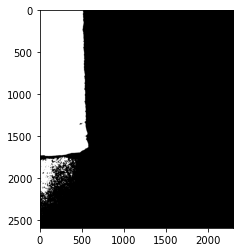

In [9]:
#testing
print("The author of this program is not affiliated with all3dp.com, I just find their guides useful and easy to follow.\n")
#plt.figure(figsize=(11,17))

#test size estimation
#img = cv.imread(path+"DimensionEstimate/40.JPG")
#plt.figure(figsize=(11,17))
#plt.imshow(determineSize(img, 6.35, 6.35))
"""
#test burns
img = cv.imread(path + "Burns/01.JPG") #01 has a burnt piece of filament in the lower right corner
burns = findBurntSpot(img)
imgWBurns = img.copy()
if len(burns) >= 1:
    for (i, c) in enumerate(burns):
        ((x, y), rad) = cv.minEnclosingCircle(c)
        center = (int(x), int(y))
        #print(center)
        cv.circle(imgWBurns, center, int(rad) , (19, 59, 149), 7)
imgWBurns = cv.cvtColor(imgWBurns, cv.COLOR_BGR2RGB)
plt.imshow(imgWBurns)
"""

#test elephant foot
img = cv.imread(path + "ElephantFoot/0.JPG")
findElephantFoot(img)

print() #empty print prevents string comments from being printed